# Import module

In [19]:
import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

# Load and preprocess the content and style images

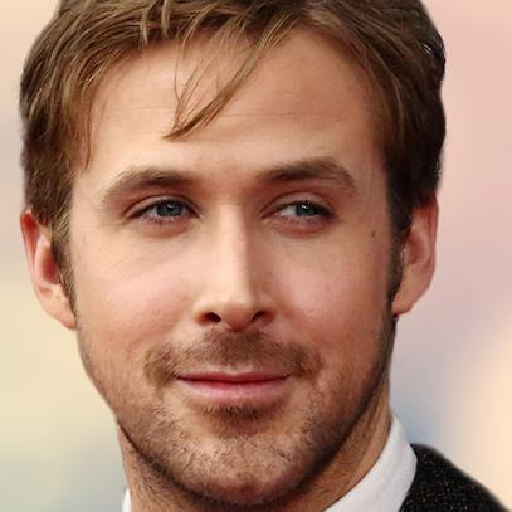

In [20]:
height = 512
width = 512

content_image_path = 'Ryan.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

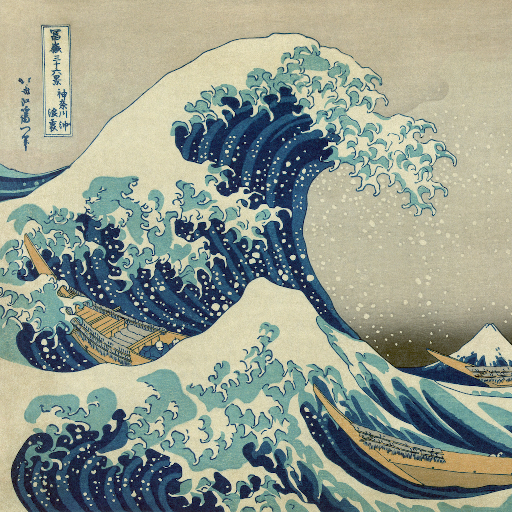

In [21]:
style_image_path = 'wave.png'
style_image = Image.open(style_image_path)
style_image = style_image.resize((height, width))
style_image

Add another dimension beyond height x width x 3 so that we can later concatenate the representations of these two images into a common data structure

In [22]:
content_array = np.array(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.array(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)


(1, 512, 512, 3)
(1, 512, 512, 3)


# Need 2 transformation
1. subtract the mean RGB value
2. Flip the ordering of the multi-dimensional array from RGB to BGR

In [23]:
content_array[:,:,:,0] -= 103.939
content_array[:,:,:,1] -= 116.779
content_array[:,:,:,2] -= 123.68
content_array = content_array[:,:,:,::-1]

style_array[:,:,:,0] -= 103.939
style_array[:,:,:,1] -= 116.779
style_array[:,:,:,2] -= 123.68
style_array = style_array[:,:,:,::-1]

# Define variables in Keras backend

also introduce a placeholder variable to store the combination image that retains the content while incorporating the style 

In [24]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

Concatenate all this image data into a single tensor that's suitable for processing by Keras VGG16

In [26]:
input_tensor = backend.concatenate([content_image,
                                   style_image,
                                   combination_image], axis=0)

# Reuse a model pre-trained for image classification to define loss functions
Only need part of the VGG16 (D)

no fully connected layers

In [27]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
             include_top=False)

In [30]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

# Style transfer problem can be posed as an optimization problem 

where the loss we want to minimize can be decomposed into 3 distinct part:

1. The content loss
2. The style loss
3. The total variation loss

In [31]:
# arbitrary but experimented parameters
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [32]:
loss = backend.variable(0.)

# The content loss

In [35]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :] # 0 = content
combination_features = layer_features[2, :, :, :] # 2 = combination

loss += content_weight * content_loss(content_image_features,
                                     combination_features)

# The style loss
First define Gram matrix

Gram matrix are proportional to the covariances of corresponding sets of features
thus captures information abouit which features tend to activate together

Computed efficiently by reshaping the feature spaces suitably and taking an outer product

features' . features 

In [39]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

# Style loss = frobenium norm of the difference between Gram matrices of the style and combination images
Frobenius Norm = Euclidean norm = the square root of the sum of the absolute squares of its elements,

In [40]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C) / (4. * (channels ** 2) * (size ** 2)))

feature_layers = ['block1_conv2',  'block2_conv2',
                 'block3_conv3', 'block4_conv3',
                 'block5_conv3',]

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :] # 1 = style
    combination_features = layer_features[2, :, :, :] # 2 = combination
    s1 = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * s1

# Total variation loss

In [41]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a+b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

# Define needed gradients and solve the optimization problem

In [42]:
grads = backend.gradients(loss, combination_image)

# Introduce Evaluator class that compute loss and gradients in 1 pass

while retrieving loss and grads. 

Done by scipy.optimize 

In [57]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):
    
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
        
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
        
evaluator = Evaluator()

# K-BFGS than SGD

In [58]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 20

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                    fprime = evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration {} completed'.format(i, end_time - start_time))

Start of iteration 0
Current loss value: 1.05517e+11
Iteration 0 completed
Start of iteration 1
Current loss value: 7.01355e+10
Iteration 1 completed
Start of iteration 2
Current loss value: 6.03242e+10
Iteration 2 completed
Start of iteration 3
Current loss value: 5.68534e+10
Iteration 3 completed
Start of iteration 4
Current loss value: 5.54529e+10
Iteration 4 completed
Start of iteration 5
Current loss value: 5.4814e+10
Iteration 5 completed
Start of iteration 6
Current loss value: 5.4464e+10
Iteration 6 completed
Start of iteration 7
Current loss value: 5.42667e+10
Iteration 7 completed
Start of iteration 8
Current loss value: 5.4147e+10
Iteration 8 completed
Start of iteration 9
Current loss value: 5.40664e+10
Iteration 9 completed
Start of iteration 10
Current loss value: 5.40088e+10
Iteration 10 completed
Start of iteration 11
Current loss value: 5.39689e+10
Iteration 11 completed
Start of iteration 12
Current loss value: 5.39388e+10
Iteration 12 completed
Start of iteration 13


# subject our output image to the inverse of the transformation

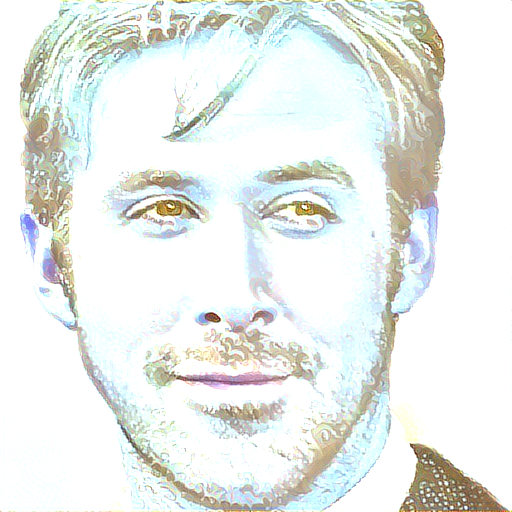

In [60]:
x = x.reshape((height, width, 3))
x = x[:,:,::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)